In [ ]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import Adam, SGD
from tqdm import tqdm
from sklearn.datasets import fetch_lfw_people
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
data = fetch_lfw_people(min_faces_per_person=7, color=True)
data.images = np.transpose(data.images, (0,3,1,2))
data.images = torch.from_numpy(data.images).to(device)
data.target = torch.from_numpy(data.target).type(dtype=torch.int16)

In [ ]:
data.images.shape

torch.Size([5095, 3, 62, 47])

In [ ]:
def triplets(data, target, net, mode="beginning", margin=0.6):
  embeddings = net(data)
  n = 3
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  except_list = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  except_list = dict()
  for i in num_list:
    if i in except_list and except_list[i] < n:
      except_list[i] += 1
    elif  i not in except_list: except_list[i] = 1
    else: continue
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    if mode =="end_pos":
      positive_final = positive[torch.argmax(dist[i][positive])]
      negative_final = random.choice(negative)
    if mode == "end_neg":
      positive_final = random.choice(positive)
      negative_final = negative[torch.argmin(dist[i][negative])]
    if mode == "end":
      positive_final = positive[torch.argmax(dist[i][positive])]
      negative_final = negative[torch.argmin(dist[i][negative])]
    if mode == "beginning":
      positive_final = random.choice(positive)
      negative_final = random.choice(negative)
    if mode == "semi-hard":
      positive_final = positive[torch.argmax(dist[i][positive])]
      if ((dist[i][positive_final] <= dist[i][negative]).cpu() & (dist[i][negative] <= dist[i][positive_final] + margin).cpu()).sum() != 0:
        negative = negative[(dist[i][positive_final] <= dist[i][negative]).cpu() & (dist[i][negative] <= dist[i][positive_final] + margin).cpu()]
      negative_final = random.choice(negative)
    # plt.imshow(data[negative_final].permute(1,2,0).cpu())
    # plt.show()
    # plt.imshow(data[i].permute(1,2,0).cpu())
    # plt.show()
    # plt.imshow(data[positive_final].permute(1,2,0).cpu())
    # plt.show()
    triplets.append((embeddings[i],embeddings[positive_final],embeddings[negative_final]))
  return triplets

In [ ]:
#acc 70-80 cant with hardtriplets
class Face_net_v1(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5), stride=(1,1),padding=(2,2))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=(1,1) ,stride=(1,1))
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1,1) ,stride=(1,1))
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=(1,1) ,stride=(2,2))
    self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=(1,1) ,stride=(1,1))
    self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1) ,stride=(1,1))
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(768, 128*4)
    self.linear2 = nn.Linear(128*4, 128*2)
    self.linear3 = nn.Linear(128*2, 128)
  def forward(self, x):
    x = F.max_pool2d(self.conv1(x),(2,2))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(self.conv3(x),(2,2))
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(self.conv5(x), (2,2))
    x = F.relu(self.conv6(x))
    x = self.flat(x)
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = F.normalize(self.linear3(x))
    return x

In [ ]:
class Face_net_v2(nn.Module):
  def __init__(self):
    nn.Module.__init__(self)
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5,5), padding=(2,2))
    self.conv2a = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=192, kernel_size=(3,3), padding=(1,1))
    self.conv3a = nn.Conv2d(in_channels=192, out_channels=192, kernel_size=(3,3),padding=(1,1))
    self.conv3 = nn.Conv2d(in_channels=192, out_channels=384, kernel_size=(3,3), padding=(1,1))
    self.conv4a = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3,3), padding=(1,1))
    self.conv4 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3,3), padding=(1,1))
    self.conv5a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),padding=(1,1))
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=(1,1))
    self.conv6a = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3),padding=(1,1))
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), padding=(1,1))
    self.flat = nn.Flatten()
    self.linear1 = nn.Linear(12544, int(12544/4))
    self.linear2 = nn.Linear(int(12544/4), 128)
  def forward(self, x):
    x = F.max_pool2d(self.conv1(x),(2,2))
    x = F.relu(self.conv2a(x))
    x = F.max_pool2d(self.conv2(x),(2,2))
    x = F.relu(self.conv3a(x))
    x = F.max_pool2d(self.conv3(x),(2,2))
    x = F.relu(self.conv4a(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5a(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6a(x))
    x =  F.max_pool2d(self.conv6(x),(2,2))
    x = self.flat(x)
    x = F.relu(self.linear1(x))
    x = F.normalize(self.linear2(x))
    return x

In [ ]:
def train_face_net(net, loss, data, optimizer, names,labels, test, epoch=5, mode="beginning", verbose=300, frequency=10, p_mode=True):
  for _ in range(epoch):
    if _ != 0: print("Current loss: ", l.item())
    labels = random.sample(labels, verbose)
    mask = []
    for i in labels:
      mask.extend(names[i])
    triplets_ = triplets(data.images[mask], data.target[mask], net, mode)
    l = torch.zeros(1, dtype = torch.float16).to(device)
    for triplet in triplets_:
      l += loss(triplet[0], triplet[1], triplet[2])
    l = l/len(triplets_)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    if _ != 0 and _%frequency==0 or _==epoch-1:
      mask = []
      for i in test:
        mask.extend(names[i])
      dist, answer = accuracy(data.images[mask], data.target[mask], net)
      acc_list = []
      dansity = 400
      for threshold in np.linspace(0,2,dansity):
        correct = 0
        for i in range(len(answer)):
          if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
            correct += 1
        acc_list.append(correct/len(answer))
      if p_mode:
        plt.plot(np.linspace(0,2,dansity), acc_list)
        plt.title("tr-acc")
        plt.show()
      print(f" Batch [{_}] Max accuracy:", max(acc_list)," | " ,"Threshold: ", np.linspace(0,2,dansity)[np.array(acc_list).argmax()])

In [ ]:
def accuracy(data, target, net):
  embeddings = net(data)
  dist = torch.cdist(embeddings, embeddings)
  triplets = []
  num_list = list(range(target.shape[0]))
  random.shuffle(num_list)
  distances_slice = []
  answers = []
  except_list = []
  for i in num_list:
    # if target[i] in except_list:
    #   continue
    # else: except_list.append(target[i])
    positive = torch.where(target == target[i])[0]
    positive = positive.tolist()
    positive.remove(i)
    negative = torch.where(target != target[i])[0]
    positive_final = random.choice(positive)
    negative_final = random.choice(negative)
    distances_slice.append(dist[i][positive_final].item())
    distances_slice.append(dist[i][negative_final].item())
    answers.append(1)
    answers.append(0)
  return distances_slice, answers

In [ ]:
names = dict()
for i, label in enumerate(data.target):
  if label.item() in names:
    names[label.item()].append(i)
  else:
    names[label.item()] = [i]

net = Face_net_v1()
# net.load_state_dict(torch.load("model_v2"))
loss = nn.TripletMarginLoss(0.3)
net.to(device)

Face_net_v1(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=768, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=128, bias=True)
)

In [ ]:
all = list(names.keys())
train = all[0:int(len(all)*0.8)]
test = all[int(len(all)*0.8):]

In [ ]:
optimizer = Adam(net.parameters(), lr=1e-3)

Current loss:  0.26708984375
Current loss:  0.26708984375
Current loss:  0.264404296875
Current loss:  0.25927734375
Current loss:  0.240478515625
Current loss:  0.216796875
Current loss:  0.197998046875
Current loss:  0.20166015625
Current loss:  0.2020263671875
Current loss:  0.1427001953125


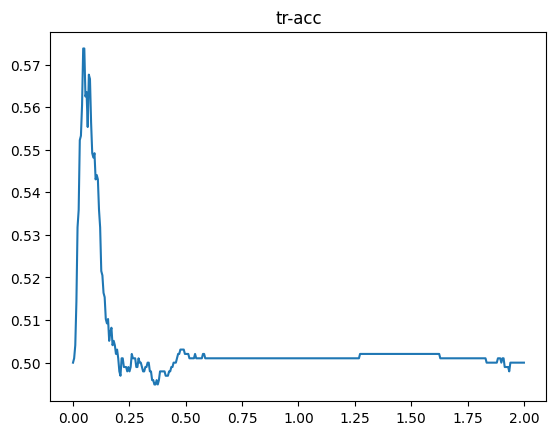

 Batch [10] Max accuracy: 0.5737704918032787  |  Threshold:  0.045112781954887216
Current loss:  0.1956787109375
Current loss:  0.2099609375
Current loss:  0.1976318359375
Current loss:  0.15966796875
Current loss:  0.161865234375
Current loss:  0.172119140625
Current loss:  0.1607666015625
Current loss:  0.15625
Current loss:  0.15380859375
Current loss:  0.1552734375


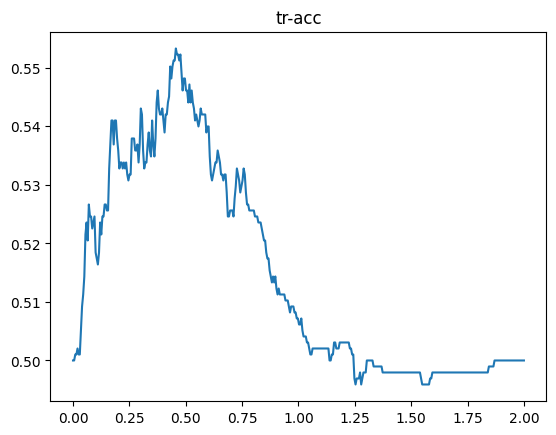

 Batch [20] Max accuracy: 0.5532786885245902  |  Threshold:  0.45614035087719296
Current loss:  0.14892578125
Current loss:  0.142822265625
Current loss:  0.143310546875
Current loss:  0.140625
Current loss:  0.132080078125
Current loss:  0.129150390625
Current loss:  0.13330078125
Current loss:  0.1337890625
Current loss:  0.1341552734375
Current loss:  0.137451171875


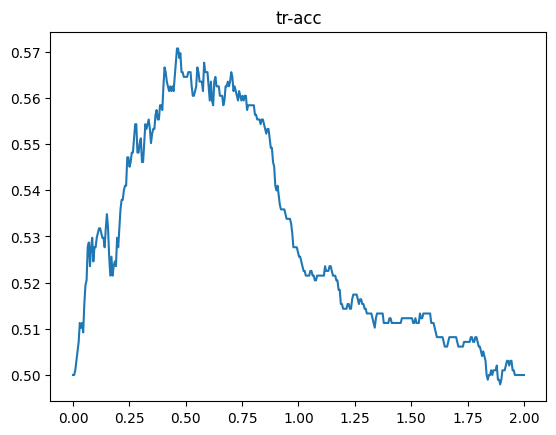

 Batch [30] Max accuracy: 0.5706967213114754  |  Threshold:  0.46115288220551376
Current loss:  0.145751953125
Current loss:  0.1317138671875
Current loss:  0.1402587890625
Current loss:  0.129638671875
Current loss:  0.1259765625
Current loss:  0.1302490234375
Current loss:  0.124267578125
Current loss:  0.1201171875
Current loss:  0.12091064453125
Current loss:  0.1134033203125


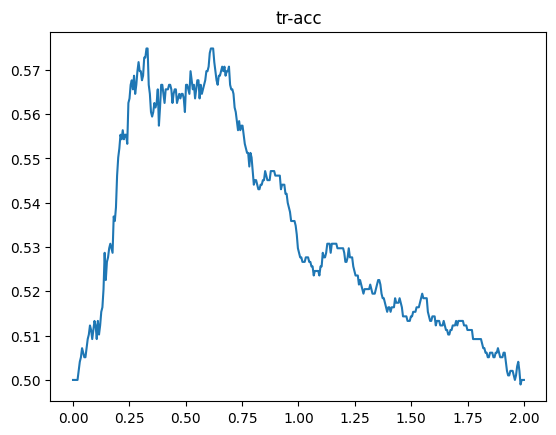

 Batch [40] Max accuracy: 0.5747950819672131  |  Threshold:  0.3258145363408521
Current loss:  0.10662841796875
Current loss:  0.1112060546875
Current loss:  0.11279296875
Current loss:  0.120849609375
Current loss:  0.11065673828125
Current loss:  0.11029052734375
Current loss:  0.127197265625
Current loss:  0.1175537109375
Current loss:  0.12200927734375
Current loss:  0.1134033203125


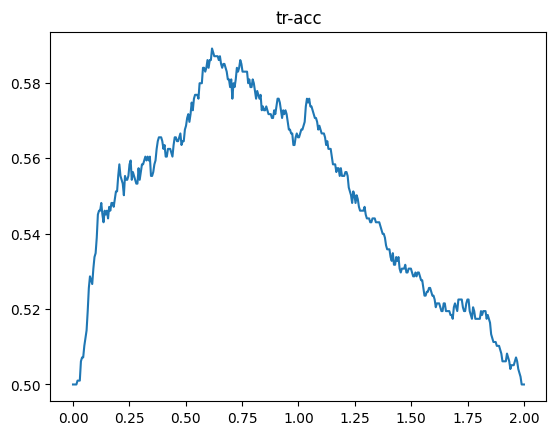

 Batch [50] Max accuracy: 0.5891393442622951  |  Threshold:  0.6165413533834586
Current loss:  0.114013671875
Current loss:  0.10791015625
Current loss:  0.109619140625
Current loss:  0.11895751953125
Current loss:  0.1134033203125
Current loss:  0.1070556640625
Current loss:  0.10986328125
Current loss:  0.10369873046875
Current loss:  0.1024169921875
Current loss:  0.11004638671875


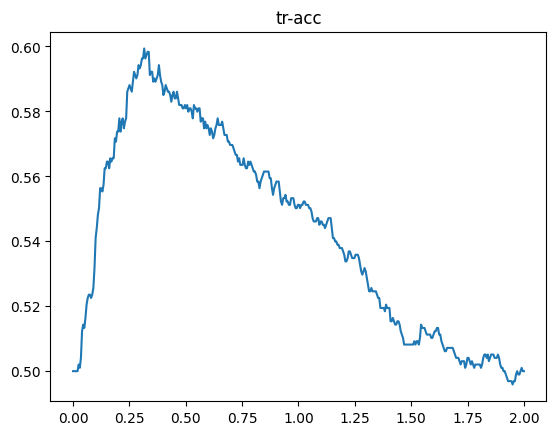

 Batch [60] Max accuracy: 0.5993852459016393  |  Threshold:  0.3157894736842105
Current loss:  0.10693359375
Current loss:  0.1029052734375
Current loss:  0.1031494140625
Current loss:  0.1031494140625
Current loss:  0.10272216796875
Current loss:  0.10784912109375
Current loss:  0.10040283203125
Current loss:  0.1029052734375
Current loss:  0.0999755859375
Current loss:  0.097412109375


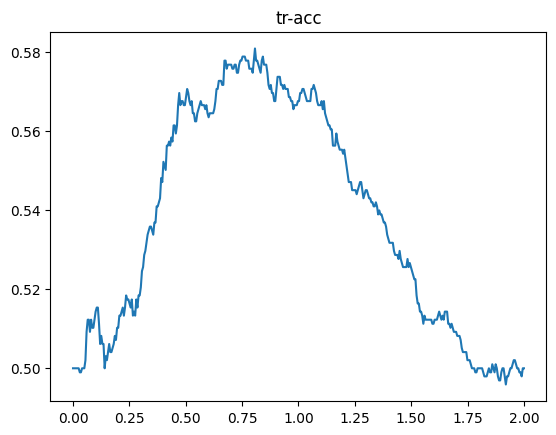

 Batch [70] Max accuracy: 0.5809426229508197  |  Threshold:  0.8070175438596491
Current loss:  0.1011962890625
Current loss:  0.10614013671875
Current loss:  0.099609375
Current loss:  0.1048583984375
Current loss:  0.09564208984375
Current loss:  0.10113525390625
Current loss:  0.1014404296875
Current loss:  0.1251220703125
Current loss:  0.11578369140625
Current loss:  0.0927734375


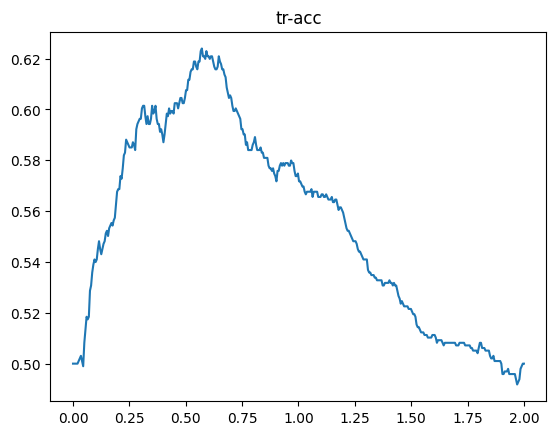

 Batch [80] Max accuracy: 0.6239754098360656  |  Threshold:  0.5714285714285714
Current loss:  0.11181640625
Current loss:  0.10772705078125
Current loss:  0.1060791015625
Current loss:  0.0948486328125
Current loss:  0.10113525390625
Current loss:  0.09686279296875
Current loss:  0.09698486328125
Current loss:  0.09918212890625
Current loss:  0.1053466796875
Current loss:  0.10333251953125


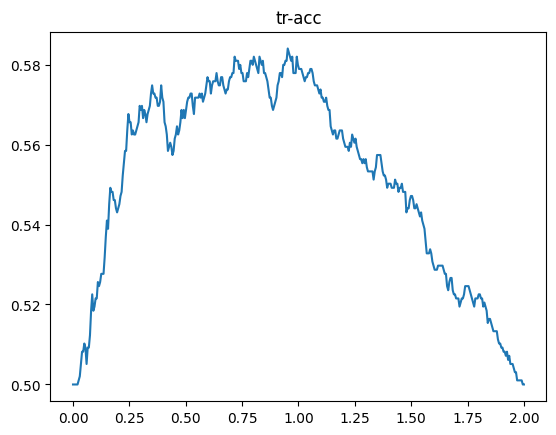

 Batch [90] Max accuracy: 0.5840163934426229  |  Threshold:  0.9523809523809523
Current loss:  0.0987548828125
Current loss:  0.09552001953125
Current loss:  0.0950927734375
Current loss:  0.09783935546875
Current loss:  0.0911865234375
Current loss:  0.1002197265625
Current loss:  0.10577392578125
Current loss:  0.09759521484375
Current loss:  0.09307861328125
Current loss:  0.105712890625


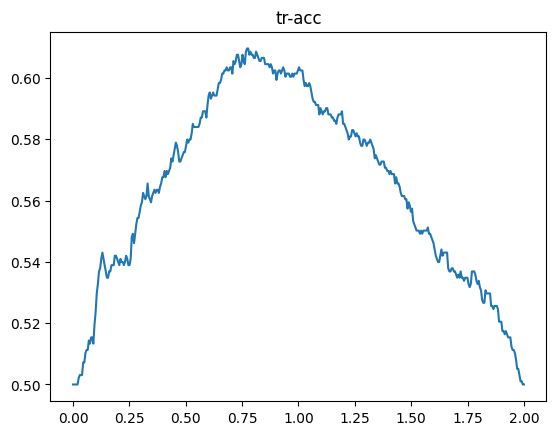

 Batch [100] Max accuracy: 0.6096311475409836  |  Threshold:  0.7719298245614035
Current loss:  0.091552734375
Current loss:  0.094482421875
Current loss:  0.10137939453125
Current loss:  0.09613037109375
Current loss:  0.09588623046875
Current loss:  0.10296630859375
Current loss:  0.10528564453125
Current loss:  0.09368896484375
Current loss:  0.0948486328125
Current loss:  0.09503173828125


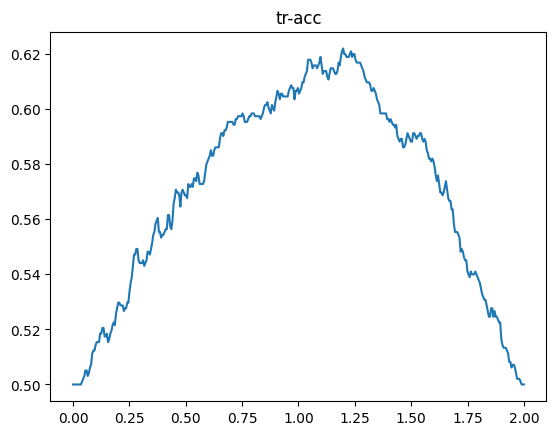

 Batch [110] Max accuracy: 0.6219262295081968  |  Threshold:  1.1979949874686717
Current loss:  0.097412109375
Current loss:  0.099609375
Current loss:  0.0911865234375
Current loss:  0.08856201171875
Current loss:  0.09368896484375
Current loss:  0.1038818359375
Current loss:  0.1019287109375
Current loss:  0.0966796875
Current loss:  0.09295654296875
Current loss:  0.10040283203125


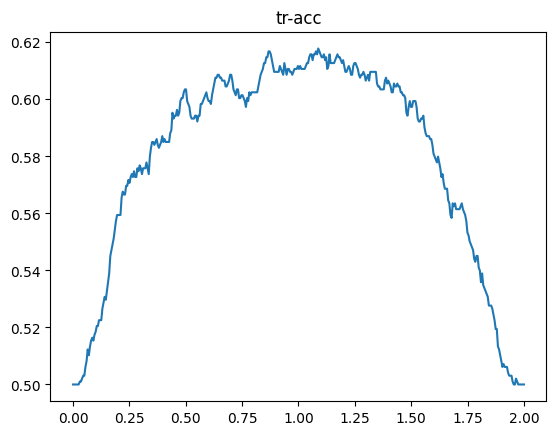

 Batch [120] Max accuracy: 0.617827868852459  |  Threshold:  1.0877192982456139
Current loss:  0.103759765625
Current loss:  0.10675048828125
Current loss:  0.104736328125
Current loss:  0.098876953125
Current loss:  0.09661865234375
Current loss:  0.09906005859375
Current loss:  0.10565185546875
Current loss:  0.100341796875
Current loss:  0.107421875
Current loss:  0.10064697265625


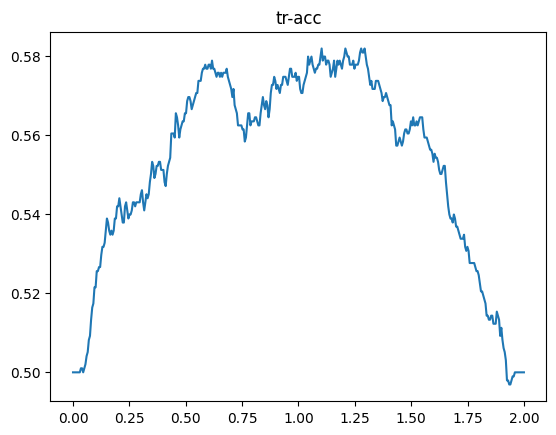

 Batch [130] Max accuracy: 0.5819672131147541  |  Threshold:  1.1027568922305764
Current loss:  0.09954833984375
Current loss:  0.09979248046875
Current loss:  0.09375
Current loss:  0.09747314453125
Current loss:  0.09130859375
Current loss:  0.09881591796875
Current loss:  0.09521484375
Current loss:  0.10076904296875
Current loss:  0.0972900390625
Current loss:  0.09228515625


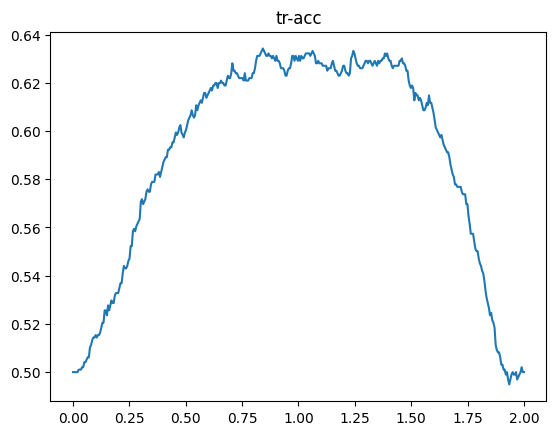

 Batch [140] Max accuracy: 0.6342213114754098  |  Threshold:  0.8421052631578947
Current loss:  0.0897216796875
Current loss:  0.10015869140625
Current loss:  0.09613037109375
Current loss:  0.09393310546875
Current loss:  0.09271240234375
Current loss:  0.09344482421875
Current loss:  0.0887451171875
Current loss:  0.08837890625
Current loss:  0.09075927734375
Current loss:  0.09112548828125


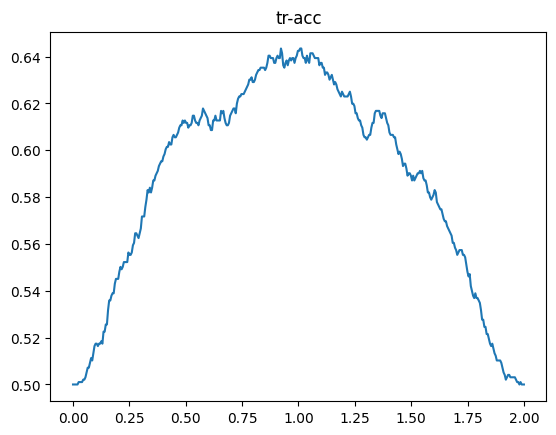

 Batch [150] Max accuracy: 0.6434426229508197  |  Threshold:  0.9223057644110275
Current loss:  0.09454345703125
Current loss:  0.083984375
Current loss:  0.0904541015625
Current loss:  0.0809326171875
Current loss:  0.07977294921875
Current loss:  0.074951171875
Current loss:  0.0865478515625
Current loss:  0.09002685546875
Current loss:  0.089599609375
Current loss:  0.0889892578125


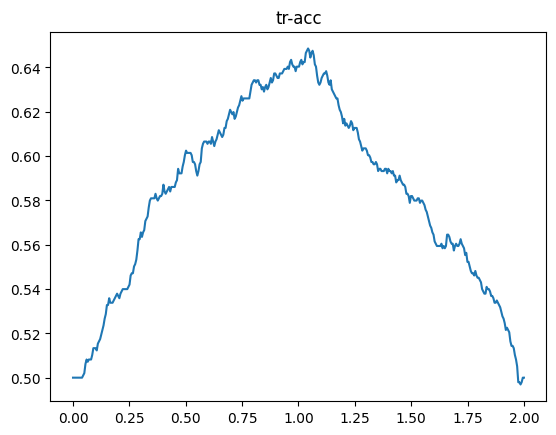

 Batch [160] Max accuracy: 0.6485655737704918  |  Threshold:  1.0426065162907268
Current loss:  0.09002685546875
Current loss:  0.088623046875
Current loss:  0.08087158203125
Current loss:  0.085205078125
Current loss:  0.07958984375
Current loss:  0.0775146484375
Current loss:  0.08197021484375
Current loss:  0.0841064453125
Current loss:  0.07916259765625
Current loss:  0.07977294921875


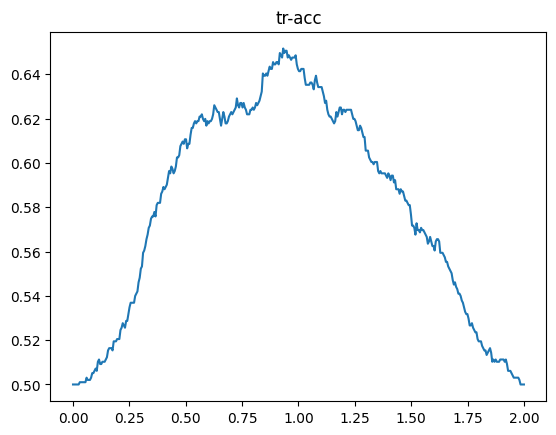

 Batch [170] Max accuracy: 0.6516393442622951  |  Threshold:  0.9323308270676691
Current loss:  0.07196044921875
Current loss:  0.0692138671875
Current loss:  0.06982421875
Current loss:  0.07098388671875
Current loss:  0.07318115234375
Current loss:  0.0711669921875
Current loss:  0.06915283203125
Current loss:  0.07244873046875
Current loss:  0.0631103515625
Current loss:  0.06597900390625


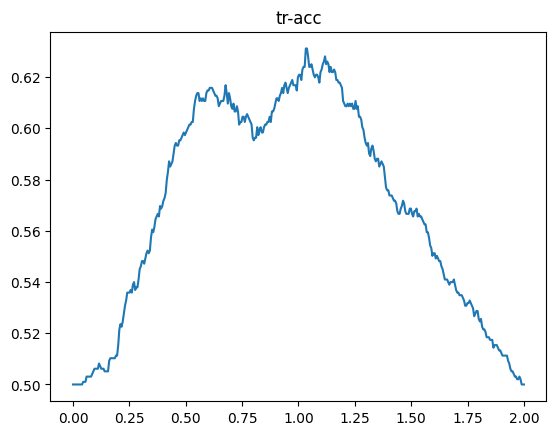

 Batch [180] Max accuracy: 0.6311475409836066  |  Threshold:  1.0325814536340852
Current loss:  0.062469482421875
Current loss:  0.061920166015625
Current loss:  0.06890869140625
Current loss:  0.056488037109375
Current loss:  0.0653076171875
Current loss:  0.05987548828125
Current loss:  0.055389404296875
Current loss:  0.0562744140625
Current loss:  0.0604248046875
Current loss:  0.0555419921875


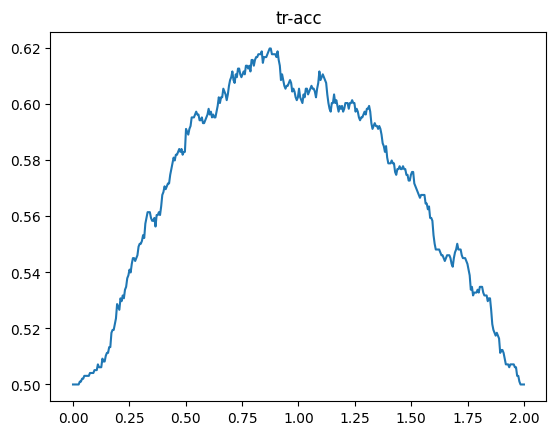

 Batch [190] Max accuracy: 0.6198770491803278  |  Threshold:  0.8721804511278195
Current loss:  0.050872802734375
Current loss:  0.0523681640625
Current loss:  0.0501708984375
Current loss:  0.0477294921875
Current loss:  0.0533447265625
Current loss:  0.0538330078125
Current loss:  0.0472412109375
Current loss:  0.054656982421875
Current loss:  0.0496826171875
Current loss:  0.049041748046875


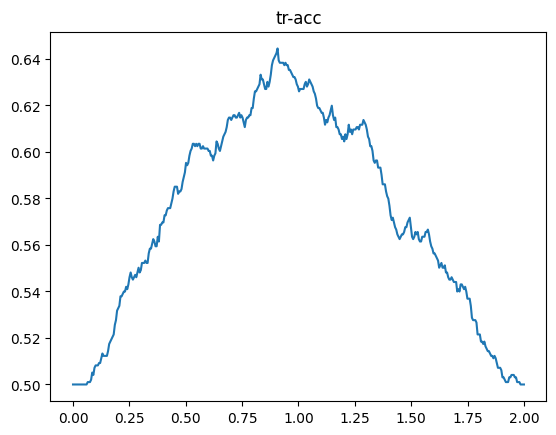

 Batch [200] Max accuracy: 0.6444672131147541  |  Threshold:  0.9072681704260651
Current loss:  0.052825927734375
Current loss:  0.048431396484375
Current loss:  0.048431396484375
Current loss:  0.04833984375
Current loss:  0.046875
Current loss:  0.04901123046875
Current loss:  0.05145263671875
Current loss:  0.052764892578125
Current loss:  0.04803466796875
Current loss:  0.049041748046875


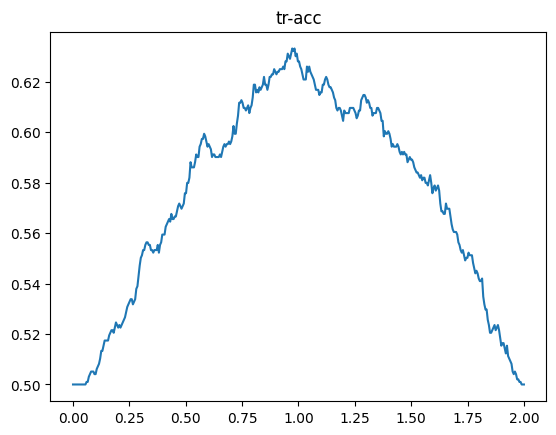

 Batch [210] Max accuracy: 0.6331967213114754  |  Threshold:  0.9724310776942355
Current loss:  0.05047607421875
Current loss:  0.054046630859375
Current loss:  0.053070068359375
Current loss:  0.04815673828125
Current loss:  0.0491943359375
Current loss:  0.045196533203125
Current loss:  0.047454833984375
Current loss:  0.045745849609375
Current loss:  0.046173095703125
Current loss:  0.0478515625


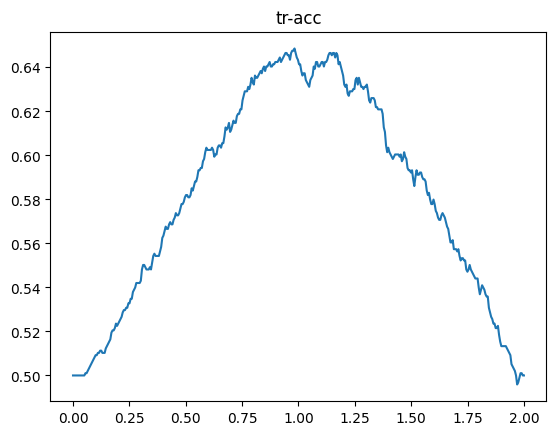

 Batch [220] Max accuracy: 0.6485655737704918  |  Threshold:  0.9824561403508771
Current loss:  0.0496826171875
Current loss:  0.046478271484375
Current loss:  0.045379638671875
Current loss:  0.048248291015625
Current loss:  0.048065185546875
Current loss:  0.046875
Current loss:  0.047607421875
Current loss:  0.042083740234375
Current loss:  0.042938232421875
Current loss:  0.0504150390625


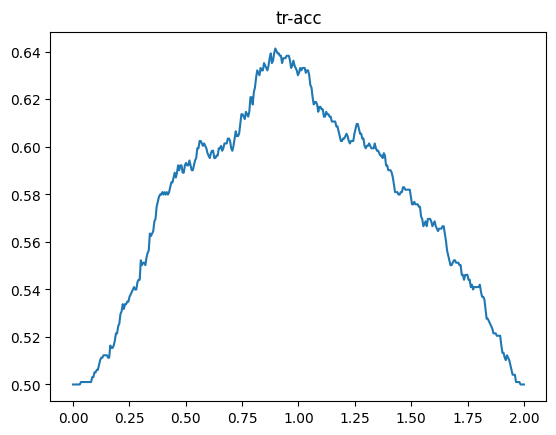

 Batch [230] Max accuracy: 0.6413934426229508  |  Threshold:  0.8972431077694235
Current loss:  0.0452880859375
Current loss:  0.0426025390625
Current loss:  0.047607421875
Current loss:  0.053375244140625
Current loss:  0.0452880859375
Current loss:  0.044830322265625
Current loss:  0.04736328125
Current loss:  0.049774169921875
Current loss:  0.050872802734375
Current loss:  0.048828125


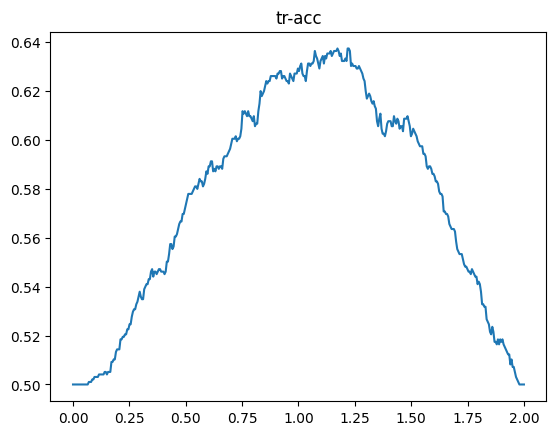

 Batch [240] Max accuracy: 0.6372950819672131  |  Threshold:  1.1729323308270676
Current loss:  0.048736572265625
Current loss:  0.04937744140625
Current loss:  0.049774169921875
Current loss:  0.0450439453125
Current loss:  0.047210693359375
Current loss:  0.040771484375
Current loss:  0.04437255859375
Current loss:  0.048004150390625
Current loss:  0.045257568359375
Current loss:  0.0487060546875


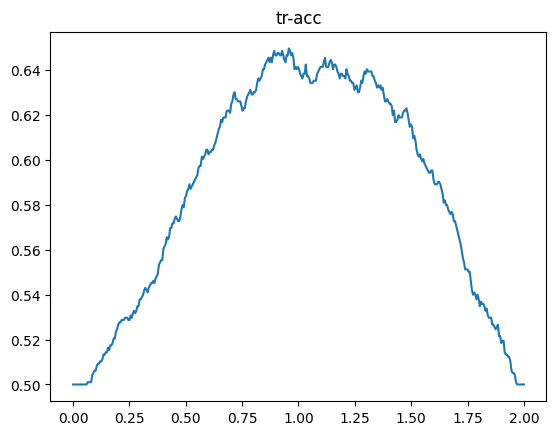

 Batch [250] Max accuracy: 0.6495901639344263  |  Threshold:  0.9573934837092731
Current loss:  0.048126220703125
Current loss:  0.048309326171875
Current loss:  0.044158935546875
Current loss:  0.046051025390625
Current loss:  0.045684814453125
Current loss:  0.041046142578125
Current loss:  0.04937744140625
Current loss:  0.045257568359375
Current loss:  0.04583740234375
Current loss:  0.046142578125


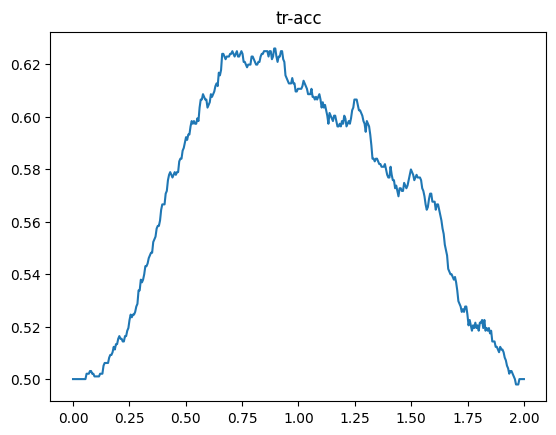

 Batch [260] Max accuracy: 0.6260245901639344  |  Threshold:  0.8922305764411027
Current loss:  0.042633056640625
Current loss:  0.04144287109375
Current loss:  0.03936767578125
Current loss:  0.038482666015625
Current loss:  0.044189453125
Current loss:  0.049285888671875
Current loss:  0.044677734375
Current loss:  0.04107666015625
Current loss:  0.043487548828125
Current loss:  0.041107177734375


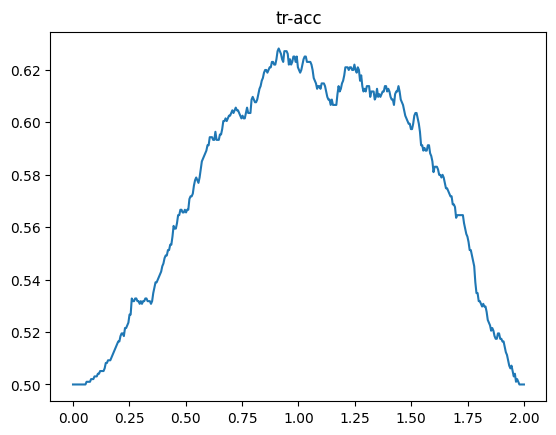

 Batch [270] Max accuracy: 0.6280737704918032  |  Threshold:  0.9122807017543859
Current loss:  0.04217529296875
Current loss:  0.0445556640625
Current loss:  0.04364013671875
Current loss:  0.042938232421875
Current loss:  0.040374755859375
Current loss:  0.03936767578125
Current loss:  0.039642333984375
Current loss:  0.04327392578125
Current loss:  0.0411376953125
Current loss:  0.042205810546875


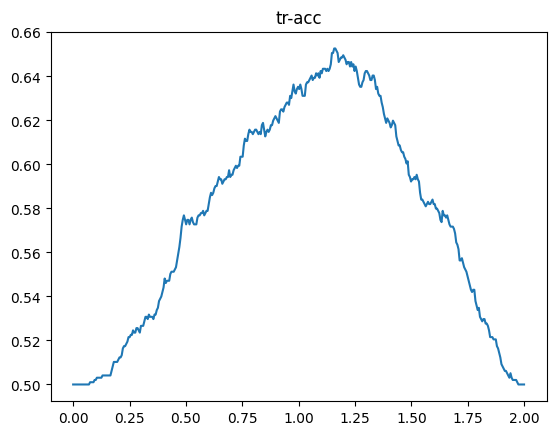

 Batch [280] Max accuracy: 0.6526639344262295  |  Threshold:  1.1578947368421053
Current loss:  0.044891357421875
Current loss:  0.039642333984375
Current loss:  0.036468505859375
Current loss:  0.039794921875
Current loss:  0.044219970703125
Current loss:  0.042388916015625
Current loss:  0.041534423828125
Current loss:  0.04180908203125
Current loss:  0.04010009765625
Current loss:  0.0426025390625


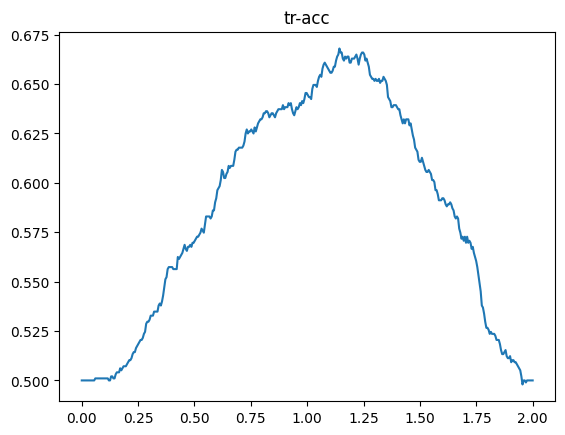

 Batch [290] Max accuracy: 0.6680327868852459  |  Threshold:  1.1428571428571428
Current loss:  0.047119140625
Current loss:  0.0419921875
Current loss:  0.041259765625
Current loss:  0.040771484375
Current loss:  0.04522705078125
Current loss:  0.044769287109375
Current loss:  0.039886474609375
Current loss:  0.0384521484375
Current loss:  0.040283203125


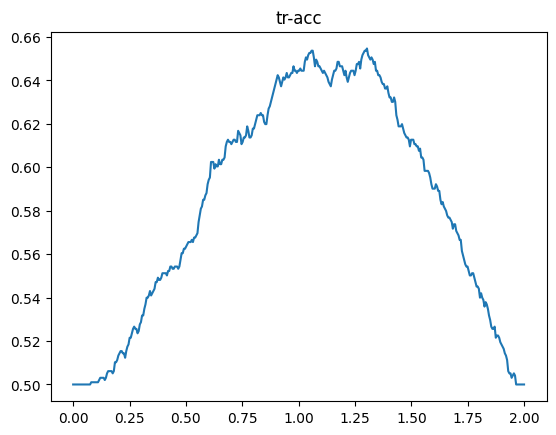

 Batch [299] Max accuracy: 0.6547131147540983  |  Threshold:  1.3032581453634084


In [ ]:
train_face_net(net, loss, data, optimizer, names, train, test, epoch=300, mode="semi-hard", verbose=50, frequency=10)

In [ ]:
torch.save(net.state_dict(), "model_v2.1")

In [ ]:
mask = []
for i in test:
  mask.extend(names[i])
dist, answer = accuracy(data.images[mask], data.target[mask], net)

In [ ]:
acc_list = []
dansity = 400
for threshold in np.linspace(0,2,dansity):
  correct = 0
  for i in range(len(answer)):
    if dist[i] < threshold and answer[i] == 1 or dist[i] >= threshold and answer[i] == 0:
      correct += 1
  acc_list.append(correct/len(answer))

Max accuracy: 0.5  |  Threshold:  0.0


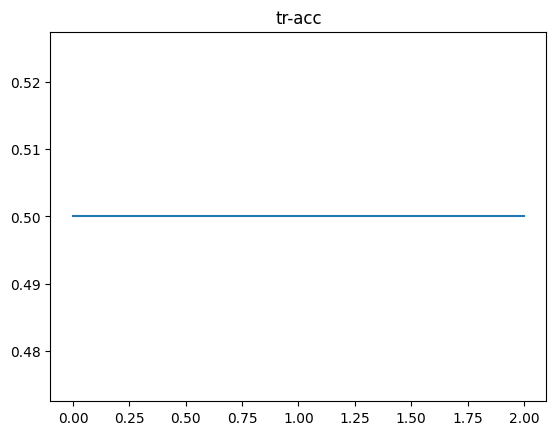

In [ ]:
plt.plot(np.linspace(0,2,dansity), acc_list)
plt.title("tr-acc")
print("Max accuracy:", max(acc_list)," | " ,"Threshold: ", np.linspace(0,1,dansity)[np.array(acc_list).argmax()])
plt.show()